Хакатон Agro-Code (предвартельная подготовка)

**Данные:**

Командам будет предоставлен размеченный датасет из нескольких сотен фотографий листьев яблони.

**Задача:**

Обучение глубокой нейросети для обнаружения заболевания листа яблони по фотографии.

Сделаем прототип по https://towardsdatascience.com/build-a-web-application-for-predicting-apple-leaf-diseases-using-pytorch-and-flask-413f9fa9276a

In [ ]:
import torch
import pickle
import numpy as np
from skimage import io
import copy
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
 
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
 
from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler
 
from matplotlib import colors, pyplot as plt
%matplotlib inline
 
# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# В замечательной статье PyTorch 101, Part 4: Memory Management and Using Multiple GPUs
# https://blog.paperspace.com/pytorch-memory-multi-gpu-debugging/
# описано что это позволяет оптимизировать использование памяти 
# и ускорить расчеты при использовании GPU Nvidia
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [ ]:
# посмотрим какую GPU нам дали
!nvidia-smi

Thu Dec 10 10:41:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Обощая все ноутбуки и документацию PyTorch, были собраны и модифицированы эти полезные функции:

### Полезные функции для сериализации и десериализации словарей (Losses и Accurancy)

In [ ]:
import pickle

def save_dict_to_file(my_dict, file_path):
    """Функция сохранения словаря my_dict в файл file_path с помощью модуля 
    pickle. (Сериализация).
    
    Parameters:

    my_dict : dict, словарь, который мы хоти сохранить.
    file_path : str, путь куда мы хотим сохранить включащий имя файла.
    """
    with open(file_path, 'wb') as handle:
        pickle.dump(my_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_dict_from_file(file_path):
    """Функция загрузки словаря из файла расположенного по пути file_path с 
    помощью модуля pickle. (Десериализация).
    
    Parameters:

    file_path : str, путь по которому мы хотим загрузить, сохраненый ранее 
        словарь.
    """
    with open(file_path, 'rb') as handle:
        unserialized_data = pickle.load(handle)
        
    return unserialized_data

def save_model(path, model, losses, acc, best_model_wts):
    """Функция для сохранения состояние нашей нейросети model 
    (ее весов state_dict()), а так же словарей с losses и accurancy за весь 
    процесс обучения.

    Parameters:

    path : str, путь по которому мы хотим сохранить веса нейросети model, 
        а так же словари losses и acc.
        словарь.
    model : обученая нейросеть, содержит веса своего текущесго состояния 
        после обучения.
    losses : dict, ключи 'train' и 'val' содежат list, в котором сохранены
        значения loss функции на каждой эпохе обучения.
    acc : dict, ключи 'train' и 'val' содежат list, в котором сохранены
        значения accurancy на каждой эпохе обучения.
    best_model_wts : model.state_dict() содержит веса обучаемой нейросети
        model, при которых была получена лучшая точность на валидационной 
        выборке.
    """

    torch.save(model.state_dict(), path + '.pth')
    torch.save(best_model_wts, path + '_best_w.pth')
    save_dict_to_file(losses, path + '_losses.pickle')
    save_dict_to_file(acc, path + '_acc.pickle') 

### Полезные функции для обучения нейросети

In [ ]:
from tqdm import tqdm_notebook
import time
import logging

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,
                scheduler=None, use_gpu=True, best_acc=None,
                flag_save_wts_to_file = False, path = None, losses=None, 
                acc=None):
    
    """Модифицированная мной функция тренеровки модели из 
    https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial

    Тестировалась в новой версии PyTorch 1.5
    Ключевые особенности:
    1. Сохраняет веса модели, если была достигнута лучшая точность на этапах 
    валидации, чем ранее на каждой эпохе в переменную best_model_wts. 
    (Далее эти веса при необходимости могут быть заружены в модель)
    2. Можно задать порог точности для сохранения best_model_wts, например,
    мы уже обучили модель на 0.9700 точности. Сохранили ее веса и продолжаем 
    обучение, зададим порог по точности не ниже полученной ранее. Тогда в 
    best_model_wts будут записаны веса модели лишь в том случае, если модель
    улучшила свою точность в процессе нового обучения.
    3. Имеет поддержку планировщика learning rate (scheduler), работающего один 
    раз за эпоху обучения.
    4. При обучении веса модели с последней эпохи обучения и при которой была 
    достигнута лучшая точность а так же losses и accurancy могут сохраняться
    на каждой эпохе обучения по указанному пути path(Я сохранял на Google Диск).
    Это удобно если вдруг обучение модели прервалось, у нас будут последние веса
    и обучение может быть продолжено с места разрыва. За это отвечает флаг 
    flag_save_wts_to_file.
    5. При включении flag_save_wts_to_file ведет лог обучения (все print) в файл.
    Это сделано на тот случай если print в Google Colab не сохраняться. При 
    обучении моделейф на локальной машине print в ноутбуке в случае выключения 
    машины скорее всего точно не сохранятся, и тут нам помогут лог-файлы.
    6. Возможно продолжение обучения с прерванного места, для этого надо просто
    загрузить в модель веса с последней эпохи, и передать в эту функцию 
    сохраненные losses как losses и accurancy как acc и достигнутое ранее 
    значение лучшей точности при которой было сохранено последнее значение
    лучших весов(тут надо смотреть лог-файл) как best_acc.
    7. Если мы используем технику раздельного lr для различных групп слоев нашей
    модели данная функция будет писать список всех lr используемых нашей моделью
    на каждой эпохе обучения. Да же если мы сипользуем отдельных lr для каждого
    слоя модели.

    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    dataloaders : torch.utils.data.DataLoader загрузчик картинок из нашего 
        dataset.
    criterion : loss функция из модуля torch.nn.
    optimizer : оптимизатор из модуля torch.optim.
    num_epochs : int, число эпох обучения.
    scheduler : планировщик learning rate из torch.optim, расчитанный на простую
    работу один раз в эпоху и не использующего losses или accurancy для своей 
    работы. (По умолчанию None).
    use_gpu : bool, используем ли мы GPU в расчетах ? (По умолчанию True)
    best_acc : float (в долях, не в процентах!), задать порог точности для 
        сохранения best_model_wts, например мы уже обучили модель на 0.9700 
        точности. Сохранили ее веса и продолжаем обучение, зададим порог по 
        точности не ниже полученной ранее. Тогда в best_model_wts будут 
        записаны веса модели лишь в том случае если модель улучшила свою 
        точность в процессе нового обучения. (По умолчанию None)
    flag_save_wts_to_file : bool, хотим ли сохранять веса модели с последней 
        эпохи обучения и при которой была достигнута лучшая точность, а так же
        losses и accurancy на каждой эпохе обучения по указанному пути path
        (Я сохранял на Google Диск).
        Это удобно если вдруг обучение модели прервалось, у нас будут последние
        веса и обучение может быть продолжено с места разрыва.
        Замедляет обучение на сохранение моделей в файл, имеет смысл 
        использовать для моделей где обучение одной эпохи длится более 5 минут.
        Тогда практически не заметно. (По умолчанию False).
    path : string, путь по которому мы будем сохранять веса модели, а так же 
        losses и accurancy. Путь состоит из пути к папке и названия модели
        Пример, path = '/content/gdrive/My Drive/folder/model_name'
        (По умолчанию False, его необходимо задать если 
        flag_save_wts_to_file = True)
    losses : dict вида {'train': list значений loss, полученных эпохе на обучающей выборке,
                        'val': list значений loss, полученных на эпохе на валидационной выборке}
            используется при продолжении обучения с места разрыва, так не нужен.
            (По умолчанию None).
    acc : dict вида {'train': list значений accurancy, полученных эпохе на обучающей выборке,
                        'val': list значений accurancy, полученных на эпохе на валидационной выборке}
            используется при продолжении обучения с места разрыва, так не нужен.
            (По умолчанию None).

    Returns:
    
    model : обученая нейросеть, содержит веса своего текущесго состояния 
        после обучения.
    losses : dict, ключи 'train' и 'val' содежат list, в котором сохранены
        значения loss функции на каждой эпохе обучения.
    acc : dict, ключи 'train' и 'val' содежат list, в котором сохранены
        значения accurancy на каждой эпохе обучения.
    best_model_wts : model.state_dict() содержит веса обучаемой нейросети
        model, при которых была получена лучшая точность на валидационной 
        выборке.
    """
    since = time.time()

    if flag_save_wts_to_file:
        if path is None:
            raise ValueError('Вы хотетите сохранять веса, но не задали путь в переменную path!')
        else:
            print('Logging...')
            logging.basicConfig(level=logging.INFO, filemode='w', filename=path + '_log_file.txt')
            logger = logging.getLogger(__name__)

    best_model_wts = copy.deepcopy(model.state_dict())
    epoch_best_acc = 0
    
    if best_acc is None:
        best_acc = 0.0
    
    if losses is None and acc is None:
        losses = {'train': [], 'val': []}
        acc = {'train': [], 'val': []}
    
    for epoch in tqdm_notebook(range(num_epochs)):
        if scheduler is None:
            lr_epoch = []
            # выводим lr для каждой группы слоев которую мы определили
            # если мы используем один lr для всех обучаемых слоев выведет его
            for param_group in optimizer.param_groups:
                lr_epoch.append(param_group["lr"])
        else:
            lr_epoch = scheduler.get_lr()
            
        print(f'Epoch {epoch}/{num_epochs - 1} lr={lr_epoch}')
        print('-' * 10)

        if flag_save_wts_to_file:
            logger.info(f'Epoch {epoch}/{num_epochs - 1} lr={lr_epoch}')
            logger.info('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # установаить модель в режим обучения
            else:
                model.eval()  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for inputs, labels in dataloaders[phase]:
                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # активируем расчет градиентов для фазы обучения
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # сделаем backward шаг оптимизатора если сейчас фаза обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # подсчитаем статистику по эпохе
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            losses[phase].append(epoch_loss)
            acc[phase].append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if flag_save_wts_to_file:
                logger.info('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # если на валидационной выборке удалось получить лучшую,
            # чем ранее точность, то запомним веса модели в best_model_wts
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epoch_best_acc = epoch
                print(f'\n***new best wts with acc {best_acc} at {epoch_best_acc} epoh***')
                if flag_save_wts_to_file:
                    torch.save(best_model_wts, path + '_best_w.pth')
                    logger.info(f'save new best wts with acc {best_acc} at {epoch_best_acc} epoh')

        if flag_save_wts_to_file:
            print(f'*** save model wts at this {epoch} epoch ! *** \n')
            torch.save(model.state_dict(), path + '.pth')
            save_dict_to_file(losses, path + '_losses.pickle')
            save_dict_to_file(acc, path + '_acc.pickle')
            logger.info(f'*** save model wts at this {epoch} epoch ! *** \n')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} at {}'.format(best_acc, epoch_best_acc))

    if flag_save_wts_to_file:
        logger.info('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        logger.info('Best val Acc: {:4f} at {}'.format(best_acc, epoch_best_acc))

    logging.shutdown() # выключаем логирование

    return model, losses, acc, best_model_wts
             
def evaluate(model, dataloader_val, DEVICE, use_gpu =True):
    '''Функция для измерения точности модели на валидационном датасете
    метрика accurancy
    
    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    dataloader_val : torch.utils.data.DataLoader загрузчик картинок из 
        валидационной выборки.
    use_gpu : bool, используем ли мы GPU в расчетах ?

    Returns:

    accurancy : float, число accurancy [0. ,1.], полученная на валидационной 
        выборке.
    '''
    model.eval() # перевели модель в режим предсказание
    
    runninig_correct = 0
    # Контекстный менеджер, который отключает вычисление градиентов.
    # отключаем вычисление градиентов, мы только предсказываем, а не обучаем.
    # экономит оперативную память GPU и ускоряет расчеты.
    with torch.no_grad(): 
        for inputs, labels in dataloader_val:
            # переносим на GPU, если оно используется
            if use_gpu:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
            # forard pass
            output = model(inputs)
            _, predicted = torch.max(output, 1)
            
            runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / len(dataloader_val.dataset)

def predict(model, test_loader):
    """Сделать предсказание нейросетью model на выборке из загрузчика 
    test_loader.
    
    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    test_loader : torch.utils.data.DataLoader загрузчик картинок из 
        валидационной или тестовой выборки.
    use_gpu : bool, используем ли мы GPU в расчетах ?
    
    Returns:

    probs : torch.tensor, массив предсказаний нашей нейросети model
    """
    model.eval() # перевели модель в режим предсказание
    logits = []

    # Контекстный менеджер, который отключает вычисление градиентов.
    # отключаем вычисление градиентов, мы только предсказываем, а не обучаем.
    # экономит оперативную память GPU и ускоряет расчеты.
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
import math
def find_lr(model, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0, use_gpu=True):
    """Функция для поиска оптимального learning rate, модифицирована мной для 
    поддержки GPU.

    Суть подхода заключается в том, чтобы обучать нейросеть на каждом батче с 
    различным уровнем lr, начиная с самого малого init_value в выбранном нами 
    диапазоне [init_value, final_value] и заканчивая самым большим final_value. 
    При этом мы будем записывать в массив значение lr и полученного на этом 
    значении lr значение loss функции. В результате мы получим таблицу
    зависимости loss от значения lr. Построив по ним график, в области
    резкого снижения полученых значений loss функции и будет оптимальный 
    для обучения lr.

    Функция взята из замечатлеьной книги книги "Ian Pointer - Programming PyTorch
    for Deep Learning - Creating and Deploying Deep Learning Applications-
    O’Reilly Media (2019).
    Ccылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)
    Chapter 4. "Transfer Learning and Other Tricks" про "Transfer Learning with ResNet50" и
    "Finding That Learning Rate".
    Сделана автором книги на основе подхода описанного в статье
    “Cyclical Learning Rates for Training Neural Networks” by Leslie Smith (2015).
    Однако популярным данный подход сделал Jeremy Howard автор курса fast.ai
    Эта функция так же сделана на основе реализации подобного подбора в 
    библиотеке fast.ai функции lr_find()
    https://towardsdatascience.com/transfer-learning-using-the-fastai-library-d686b238213e
    Функция из fast.ai лучше, но это сделана на чистом PyTorch и хорошо
    показывает идею.

    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    dataloaders : torch.utils.data.DataLoader загрузчик картинок из нашего 
        dataset.
    loss_fn : loss функция из модуля torch.nn.
    optimizer : оптимизатор из модуля torch.optim.
    init_value : float, начальное значение learning rate, из выбранного нами
        диапазона.
    final_value : float, конечное значение learning rate.
    use_gpu : bool, используем ли мы GPU в расчетах ?

    Returns:

    log_lrs : list, содержащий степень 10 от исследованых нами lr(десятичный 
        логорифм от lr)
    losses : list, содержащий полученные значения loss функции.
    """
    model.train() # переключаем модель в режим обучения

    number_in_epoch = len(dataloaders['train']) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, labels in dataloaders['train']:
        if use_gpu:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        batch_num += 1
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr

    return log_lrs[10:-5], losses[10:-5]

In [ ]:
def print_learn_params(model):
    """Функция напечатает все веса нейросети model, которые мы обучаем.

    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная
        в PyTorch или предобученная из torchvision.models.

    Returns: list, спиок параметров слоев нейросети, которые мы обучаем,
            будет отдан оптимизатору.
    """
    print('Params to update:')
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

    return params_to_update

def print_params(model):
    """Функция напечатает все веса нейросети model, которые мы можем обучать.

    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная
        в PyTorch или предобученная из torchvision.models.

    Returns:

    params_number_name: python dict вида {'num': список значений порядковых 
                                                номеров слоя нейросети,
                                        'param_name': название слоев нейросети
                                         идущих по порядку}
    """
    print('Params to update:')
    i = 0
    params_to_learn = {'num':[], 'param_name':[]}
    for name,param in model.named_parameters():
        params_to_learn['num'].append(i)
        params_to_learn['param_name'].append(name)
        print(f"{i} {name}")
        i += 1

    return params_to_learn


def show_param_lr_plots(params_number_name, lrs, layer_names=False, figsize=None):
    """Функция для построения графика значений learning rate(lr) по всем слоям 
    которые мы учим нейросети, чтобы посмотреть какие lr мы задаем для слоев
    нейросети.

    Parameters:

    params_number_name: python dict вида {'num': список значений порядковых номеров слоя нейросети,
                                     'param_name': название слоев нейросети идущих по порядку}

    lrs: python list, содержит значения learning rate для каждого из слоев нейросети.
        его длинна должна равняться число слоев нейросети.

    layer_names : bool, хоти ли мы отобразить по оси Х названия слоев нейросети? (по умолчанию False)
    figsize: задать соотношение сторон для графика (figsize для figure нашего графика)
    """
    plt.clf()

    if figsize is None:
        figsize = (12, 8)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(params_number_name['num'], lrs, 'r', label='learning rate')
    ax.set_title('learning rate for all layers of neuronet')
    ax.set_xlabel('layers')
    ax.set_ylabel('lr')
    if layer_names:
        ax.set_xticks(params_number_name['num'])
        ax.set_xticklabels(params_number_name['param_name'])
        ax.xaxis.set_tick_params(rotation=90)
    plt.legend()
    plt.show()


def set_learn_params(model, lrs):
    """Функция которая задаст каждому слою нейросети значения learning rate из списка lrs.

    Parameters:

    model: torchvision.models или самописаная нейронная сеть созданная
        в PyTorch или предобученная из torchvision.models.

    lrs: python list, содержит значения learning rate для каждого из слоев нейросети.
    его длинна должна равняться число слоев нейросети.

    Returns: list, спиок слоев нейросети, которые мы обучаем
            и lr для каждого из них, будет отдан оптимизатору.
    """
    print('Params to learn:')
    learn_params = []
    i = 0

    for name, param in model.named_parameters():
        if param.requires_grad == True:
            learn_params.append({'params': param, 'lr': lrs[i]})
            print(f'{lrs[i]} {name}')
        i += 1

    return learn_params

### Оптимизатор AdaShift (взят из репозитория МФТИ [AdaShift](https://github.com/MichaelKonobeev/adashift/blob/master/adashift/optimizers.py))

В данном репозитории лежит самостоятельно написанная сотрудниками МФТИ реализация нового оптимизатора AdaShift для PyTorch.

https://github.com/MichaelKonobeev/adashift/blob/master/adashift/optimizers.py

там же дана ссылка на оригинальную статью по данный оптимизатор

Reproducing of the AdaShift: Decorrelation and Convergence of Adaptive Learning Rate Methods as a part of ICLR Reproducibility Challange 2019. See our report.

Можно завести отдельную ячейку с данным оптимизатором и использовать его для обучения нейросети )

In [ ]:
""" Implements AdaShift optimizer. """
# здесь я просто взял готовый оптимизатор AdaShift, релизованный в реползитории 
# МФТИ (https://github.com/MichaelKonobeev/adashift/blob/master/adashift/optimizers.py)
from collections import deque

from torch.optim import Optimizer


class AdaShift(Optimizer):
  r""" Implements AdaShift algorithm.
  See https://openreview.net/forum?id=HkgTkhRcKQ
  Arguments:
    params (iterable): iterable of parameters to optimize or dicts defining
      parameter groups
    lr (float, optional): learning rate
    keep_num (int): number of gradients used to compute first moment
      estimation.
    betas (Tuple[float, float], optional): coefficients used for computing
     running averages of gradient and its square
    eps (float, optional): term added to the denominator to improve
      numerical stability
    reduce_func (callable or None): function applied to squared gradients
      to further reduce the correlation. If None, no function is applied.
  """
  def __init__(self, params, lr=1e-3, keep_num=10, betas=(0.9, 0.999),
               eps=1e-10, reduce_func=torch.max):
    beta1, _ = betas
    exp_weight_sum = sum(beta1 ** i for i in range(keep_num))
    first_grad_weight = beta1 ** (keep_num - 1) / exp_weight_sum
    last_grad_weight = 1. / exp_weight_sum
    defaults = dict(lr=lr, keep_num=keep_num, betas=betas,
                    eps=eps, reduce_func=reduce_func,
                    first_grad_weight=first_grad_weight,
                    last_grad_weight=last_grad_weight)
    super(AdaShift, self).__init__(params, defaults)

  def step(self, closure=None):
    loss = None
    if closure is not None:
      loss = closure()

    for group in self.param_groups:
      for p in group["params"]:
        if p.grad is None:
          continue
        grad = p.grad.data
        if grad.is_sparse:
          raise RuntimeError("AdaShift does not support sparse gradients.")

        state = self.state[p]
        if len(state) == 0:
          state["step"] = 1
          state["grad_deque"] = deque([grad.clone()], maxlen=group["keep_num"])
          state["exp_avg"] = torch.zeros_like(p.data)
          state["exp_avg_sq"] = torch.zeros_like(p.data)
          continue

        grad_deque = state["grad_deque"]
        exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]

        state["step"] += 1
        grad_apply = len(grad_deque) == group["keep_num"]
        offset_grad = grad_deque[0]
        grad_deque.append(grad.clone())
        if not grad_apply:
          continue

        first_grad_weight = group["first_grad_weight"]
        last_grad_weight = group["last_grad_weight"]
        beta1, beta2 = group["betas"]
        (exp_avg.sub_(first_grad_weight, offset_grad).mul_(beta1)
         .add_(last_grad_weight, grad))

        reduce_func = group["reduce_func"] or (lambda x: x)
        reduced_grad_sq = reduce_func(offset_grad.mul_(offset_grad))
        exp_avg_sq.mul_(beta2).add_(1 - beta2, reduced_grad_sq)
        bias_correction = 1 - beta2 ** (state["step"] - group["keep_num"])
        denom = exp_avg_sq.div(bias_correction).sqrt_().add_(group["eps"])

        p.data.addcdiv_(-group["lr"], exp_avg, denom)

    return loss

### Полезные функции для построения графиков (Losses и Accurancy)

In [ ]:
# Скользящее среднее
def smooth_curve(points, factor=0.9):
    """Функция для сглаживания графиков
    
    Parameters:

    points : list or numpy.array содержащий значения амплитудных отсчетов
        графика, который необходимо сгладить.
    factor : float, коэффициент сглаживания.

    Returns:

    points : list содержащий значения амплитудных отсчетов сглаженного графика.
    """
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def show_losses_plots(losses, smooth_flag = False, min = 0):
    """Функция для построения графиков loss функции по всем эпохам обучения 
    нейросети.
    
    Parameters:

    losses : dict, ключи 'train' и 'val' содежат list, в котором сохранены
        значения loss функции на каждой эпохе обучения.
    smooth_flag : bool, осуществить сглаживание графика ?
    min : int, с какой эпохи начать ось абсцисс ?
    """
    plt.clf()

    losses_train, losses_test = losses['train'], losses['val']
    epochs = np.arange(len(losses_train))

    #Сглаживаем ли мы графики функций потерь?
    if smooth_flag:
      losses_train = smooth_curve(losses_train)
      losses_test = smooth_curve(losses_test)

    # Построим график лосса при обучении и валидации
    plt.plot(epochs[min:], losses_train[min:], 'r', label='Training loss')
    plt.plot(epochs[min:], losses_test[min:], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def show_acc_plots(acc, smooth_flag = False, min = 0):
    """Функция для построения графиков accurancy по всем эпохам обучения 
    нейросети.
        
    Parameters:

    acc : dict, ключи 'train' и 'val' содежат list, в котором сохранены
        значения accurancy функции на каждой эпохе обучения.
    smooth_flag : bool, осуществить сглаживание графика ?
    min : int, с какой эпохи начать ось абсцисс ?
    """
    plt.clf()

    acc_train, acc_test = acc['train'], acc['val']
    epochs = np.arange(len(acc_train))

    #Сглаживаем ли мы графики функций точности?
    if smooth_flag:
      acc_train = smooth_curve(acc_train)
      acc_test = smooth_curve(acc_test)

    # Построим график лосса при обучении и валидации
    plt.plot(epochs[min:], acc_train[min:], 'r', label='Training acc')
    plt.plot(epochs[min:], acc_test[min:], 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

### Функции для оценки точности (**confusion** matrix, и точность по каждому классу)

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Функция из документации matplotlib, отрисовывающая confusion matrix 
    Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html  

    Parameters:

    cm : Рассчитанная confusion matrix возвращаемая функцией confusion_matrix
        из sklearn. Или аналогичная структура данных.
    classes : (set or list or tuple) названия классов.
    title : str, название диаграммы.
    cmap : цветовая палитра bp matplotlib для отрисовки значений 
        confusion matrix цветом.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    
def show_confusion_matrix_fucn(model, dataloaders):
    """Построить диаграмму confusion matrix и посчитать точность предсказаний 
    модели по каждому классу по метрике accurancy
    
    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    dataloaders : torch.utils.data.DataLoader загрузчик картинок из нашего 
        dataset.

    Returns:

    y_test_all : numpy.array правильные классы.
    predictions_all : numpy.array предсказания нейросети.
    feature_names : названия классов.
    """
    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()

    # Пройдём по всему validation датасету и запишем ответы сети
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            predictions = model(inputs.to(DEVICE))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)

            # Аналог append для list
            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()

    # Функция из sklearn, создаёт confusion матрицу
    cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
    # Выведем её
    plot_confusion_matrix(cm, feature_names, normalize=True)
    
    return y_test_all, predictions_all, feature_names
  
def accurancy_for_each_class(y_test_all, predictions_all, feature_names):
    """Функция выводит accurancy полученное нашей нейросетью на каждом из 
    классов классификации.
    
    Parameters:

    y_test_all : numpy.array правильные классы.
    predictions_all : numpy.array предсказания нейросети.
    feature_names : названия классов.
    """

    class_correct = [0 for i in range(classes_number)]
    class_total = [0 for i in range(classes_number)]

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(classes_number):
        print('Accuracy of %5s\t%2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

### Еще несколько полезных функций

In [ ]:
def classes_number_from_labels(train_val_labels):
    """Функция возвращает число уникальных классов из list train_val_labels"""
    return len(np.unique(train_val_labels))

def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

def create_dct_path_labels(train_files, train_labels):
    """Функция создает словарь dct, в котором ключами является названия классов 
    из train_labels, а значениями список из путей к картинкам соответсвующих 
    этим классам из train_files.
    
    Parameters:

    train_files : list, список содержащий пути к картинкам выборки.
    train_labels: list, список содержащий метки классов к картинкам из 
        train_files.

    Returns:

    dct_simpsons : dct, словарь в котором ключами является названия классов из 
    train_labels, а значениями список из путей к картинкам соответсвующих этим 
    классам из train_files.
    """
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    """Функция напечать все пары ключ-значение в словаре, переданном в качестве 
    аргумента"""
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

def count_weights(dct_simpsons):
    """Функция расчета весов.
    
    Parameters:

    dct_simpsons : словарь dict с ключами соответсвующими
        названиям классов, и значениями, соответвующими колчеству этих классов
        в выборке

    Returns:

    dct_simpsons_wht : dct, словарь в котором ключами является названия классов,
        а значениями веса соответсвующих этим классам из выборки.
    """
    dct_simpsons_wht = {}
    for key in dct_simpsons:
        dct_simpsons_wht.update({key:1. / dct_simpsons[key]})

    return dct_simpsons_wht

def create_sample_weights_from_labels(train_val_labels, dct_simpsons_wht):
    """Создать torch.tensor с весами, вычисленным по количествку картинок в 
    каждом классе, соответвующим картинкам. 
    Необходимо для torch.utils.data.WeightedRandomSampler
    
    Parameters:

    train_labels: list, список содержащий метки классов к картинкам из 
        train_files.
    dct_simpsons_wht : словарь: ключ название класса, значение вес для данного 
        класса

    Returns:

    sampler_weights : torch.tensor с весами из dct_simpsons_wht, вычисленным 
        по количествку картинок в каждом классе, соответвующим списку классов 
        картинок из выборки train_val_labels.
    """
    samples_weight = []
    for label_i in train_val_labels:
        samples_weight.append(dct_simpsons_wht[label_i])

    return torch.from_numpy(np.array(samples_weight))

# Предварительная скачка датасета (Делалось в самом начале, сейчас не нужно!)

In [ ]:
# клонируем репозиторий "PlantVillage-Dataset"
!git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 33.37 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


In [ ]:
!zip -r apple.zip /content/PlantVillage-Dataset/raw/color

In [ ]:
files.download('apple.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Загрузка подготовленного датасета

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# раззиповка архива, необходимо сделать при первом запуске ноутбука,
# в дальнейшем файлы уже будут на жестком диске виртуальной машины Google Colab 
# и раззиповывать архив повторно с Google Drive не требуется. Команда 
# поддерживает перезапись картинок при распаковке, если не уверены, что все 
# распаковалось верно можно вызвать ее повторно.
 
!unzip -o /content/gdrive/MyDrive/AgroCode_pre_snippets/dataset/PlantVillageDatasetApple.zip

# Разбиение датасета на train, val, test (Ненужна, делалась в начале 1 раз)

In [ ]:
# определяем данные на которых будем обучаться 'train' и 'val' и те накоторых будем тестировать модель 'test'
DIR = Path('/content/PlantVillageDatasetApple')

files = sorted(list(DIR.rglob('*.JPG')))

In [ ]:
labels = [path.parent.name for path in files] # классы train

In [ ]:
# посмотрим сколько всего классов
print(np.unique(labels))
print(len(np.unique(labels)))

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy']
4


In [ ]:
# Создадим словарь в которм будут классы персонажей и кличество их картинок
dct_apples = create_dct_from_labels(labels)

# выведим на печать класс : количесвто картинок
print_dct(dct_apples)

# совпадает со статьей все, хорошо.

Apple___Apple_scab	630
Apple___Black_rot	621
Apple___Cedar_apple_rust	275
Apple___healthy	1645


In [ ]:
# разделяем все фалы на train_val и test(20%) выборки
train_val_files, test_files = train_test_split(files,
                                           test_size=0.20,
                                           stratify=labels)

train_val_labels = [path.parent.name for path in train_val_files] # классы train_val
test_labels = [path.parent.name for path in test_files]     # классы test

In [ ]:
# разделяем train на train и val(10%) выборки
train_files, val_files = train_test_split(train_val_files,
                                           test_size=0.10,
                                           stratify=train_val_labels)

train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
# выведим на печать класс : количесвто картинок
print(create_dct_from_labels(train_labels))

{'Apple___Apple_scab': 454, 'Apple___Black_rot': 447, 'Apple___Cedar_apple_rust': 198, 'Apple___healthy': 1183}


In [ ]:
# выведим на печать класс : количесвто картинок
print(create_dct_from_labels(val_labels))

{'Apple___Apple_scab': 50, 'Apple___Black_rot': 50, 'Apple___Cedar_apple_rust': 22, 'Apple___healthy': 132}


In [ ]:
# выведим на печать класс : количесвто картинок
print(create_dct_from_labels(test_labels))

{'Apple___Apple_scab': 126, 'Apple___Black_rot': 124, 'Apple___Cedar_apple_rust': 55, 'Apple___healthy': 330}


In [ ]:
# сохраняем разбиение нашей выборки для того, чтоб разные модели
# тестировались на одних и тех же выборках
data_save_path = '//content//gdrive//MyDrive//AgroCode_pre_snippets//dataset//'

datas = [train_files, train_labels, val_files, val_labels, test_files, test_labels]
file_names = ['train_files.pickle', 'train_labels.pickle', 'val_files.pickle', 'val_labels.pickle', 'test_files.pickle', 'test_labels.pickle']

for data_i, file in zip(datas, file_names):
    
    with open(data_save_path + file, 'wb') as f:
        pickle.dump(data_i, f)

# Загружаем, созданное ранее разбиение

In [ ]:
# загружаем сохранненное разбиение, чтобы нейросети учились
# на одних и тех же выборках
data_load_path = '//content//gdrive//MyDrive//AgroCode_pre_snippets//dataset//'
 
with open(data_load_path + 'train_files.pickle', 'rb') as f:
    train_files = pickle.load(f)
 
with open(data_load_path + 'train_labels.pickle', 'rb') as f:
    train_labels = pickle.load(f)
 
with open(data_load_path + 'val_files.pickle', 'rb') as f:
    val_files = pickle.load(f)
 
with open(data_load_path + 'val_labels.pickle', 'rb') as f:
    val_labels = pickle.load(f)
 
with open(data_load_path + 'test_files.pickle', 'rb') as f:
    test_files = pickle.load(f)
 
with open(data_load_path + 'test_labels.pickle', 'rb') as f:
    test_labels = pickle.load(f)

## Dataset


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class AppleDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит изменения размера картинок, аугментации и преобразование в тензоры
    PyTorch
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        # кодировщик имен классов
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            path = '/content/gdrive/MyDrive/AgroCode_pre_snippets/model/'
            with open(path + 'label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(RESCALE_SIZE),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

        # трансформация с аугментацией для обучающей выборки средствами PyTorch
        transform_augment = transforms.Compose([
            transforms.Resize(size=(256, 256)),
            transforms.RandomResizedCrop(RESCALE_SIZE),
            transforms.RandomHorizontalFlip(),
            # transforms.RandomRotation(40),
            # transforms.RandomPerspective(),
            # transforms.ColorJitter(hue=.1, saturation=.1),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])

        # У нас тр режима датасета 
        # DATA_MODES = ['train', 'val', 'test']
        # train - обчающая выборка на которой мы обучаем нейросеть 
        # (есть картинки и ответы к ним)
        # val - валидационная выборка на которой мы тестируем как хорошо
        #  нейросеть обучилась! (есть картинки и ответы к ним)
        # test - тестовая выборка на которой мы предсказываем ответы для
        #  скора в соревновании (есть картинки ответов нет!)

        if self.mode == 'test': # если тестовая выборка у нас нет ответов и
            x = transform(x)    # датасет не должен аугментировать картинки
            return x
        else:
            if self.mode == 'train': # аугментируем обучающую выборку
                x = transform_augment(x)
            else:
                x = transform(x) # не аугментируем валидационную выборку

            # для train или val выборок у нас есть ответы по классам
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

### Ручной oversampling до 100 картинок (Выполняется для всех нейросетей в подзаголовках заголовка Теперь обучаем лучшими подходами)



In [ ]:
BATCH_SIZE = 16

# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

val_dataset = AppleDataset(val_files, mode='val')
new_train_dataset = AppleDataset(new_train_files, mode='train')

# определим загрузщики данных без взвешивания классов для их балансировки простой вариант
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

# Ничего не изменилось всех картинок и так больше 100!
# исходный вариант {'train': 2282, 'val': 254}
dataset_sizes

{'train': 2282, 'val': 254}

#ResNet-34

In [ ]:
# Создаём сеть
model_resnet= models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
# посмотрим на сеть от которой мы делаем transfer learning
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Заменяем родной классификатор model на наш новый линейный классификатор
classes_number=4
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, classes_number)

## Подберем оптимальный learning rate для ResNet-152 (подбор learning rate осуществляем на классификаторе)

In [ ]:
for param in model_resnet.parameters():
    param.requires_grad = False

for param in model_resnet.fc.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры в нашей модели можно обучать
print_params(model_resnet)

Params to update:
0 conv1.weight
1 bn1.weight
2 bn1.bias
3 layer1.0.conv1.weight
4 layer1.0.bn1.weight
5 layer1.0.bn1.bias
6 layer1.0.conv2.weight
7 layer1.0.bn2.weight
8 layer1.0.bn2.bias
9 layer1.1.conv1.weight
10 layer1.1.bn1.weight
11 layer1.1.bn1.bias
12 layer1.1.conv2.weight
13 layer1.1.bn2.weight
14 layer1.1.bn2.bias
15 layer1.2.conv1.weight
16 layer1.2.bn1.weight
17 layer1.2.bn1.bias
18 layer1.2.conv2.weight
19 layer1.2.bn2.weight
20 layer1.2.bn2.bias
21 layer2.0.conv1.weight
22 layer2.0.bn1.weight
23 layer2.0.bn1.bias
24 layer2.0.conv2.weight
25 layer2.0.bn2.weight
26 layer2.0.bn2.bias
27 layer2.0.downsample.0.weight
28 layer2.0.downsample.1.weight
29 layer2.0.downsample.1.bias
30 layer2.1.conv1.weight
31 layer2.1.bn1.weight
32 layer2.1.bn1.bias
33 layer2.1.conv2.weight
34 layer2.1.bn2.weight
35 layer2.1.bn2.bias
36 layer2.2.conv1.weight
37 layer2.2.bn1.weight
38 layer2.2.bn1.bias
39 layer2.2.conv2.weight
40 layer2.2.bn2.weight
41 layer2.2.bn2.bias
42 layer2.3.conv1.weight
43 

{'num': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109],
 'param_name': ['conv1.weight',
  'bn1.weight',
  'bn1.bias',
  'layer1.0.conv1.weight',
  'layer1.0.bn1.weight',
  'layer1.0.bn1.bias',
  'layer1.0.conv2.weight',
  'layer1.0.bn2.weight',
  'layer1.0.bn2.bias',
  'layer1.1.conv1.weight',
  'layer1.1.bn1.weight',
  'layer1.1.bn1.bias',
  'layer1.1.conv2.weight',
  'layer1.1.bn2.we

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_resnet)

Params to update:
	 fc.weight
	 fc.bias


In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.Adam(params_to_update, lr=1e-3, amsgrad=True)

# Задем планировщик изменения learning rate нашего оптимизатора.
# будет просто умножать lr optimizer на gamma, каждые step_size эпох.
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Использовать ли GPU
model_resnet = model_resnet.cuda()

In [ ]:
# подбор оптимального lr для классификатора model.fc
logs, losses = find_lr(model_resnet, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

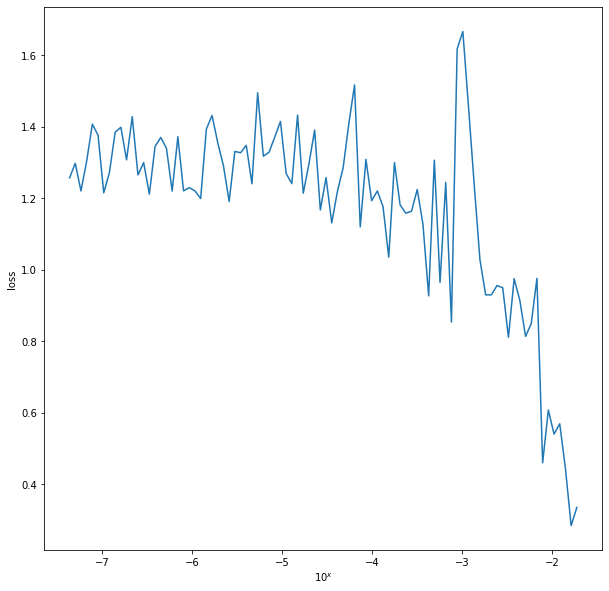

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

По оси абсцисс у нас значение lr ее степени 10 (например x=-2 , значит что lr=10**-2=0.01) по оси ординат показаны значения loss функции полученные при даном lr. Значение оптимального lr наблюдается там где у нас видно резкое спадание значения loss функции по графику. Резкий спад наблюдается от lr=[10**-4, 10**-2] , поэтому в данном случае оптимальным будет lr=10**-3.

In [ ]:
# из графика видно, что лучший lr для это 1e-3
found_lr = 1e-2
found_lr

0.01

веса подобраны перезапускаем ноутбук, только теперь переходим сразу к обучению модели без подбора learning_rate

### Обучение ResNet подходом Differential Groups Layers

In [ ]:
BATCH_SIZE

16

In [ ]:
# теперь нам необходимо сделать все веса обучаемыми снова!
for param in model_resnet.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_resnet)

Params to update:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2.3.bn1

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()
 
# Дифференциальное обучение подход взят из 
# https://blog.slavv.com/differential-learning-rates-59eff5209a4f
# и книги Ian Pointer - Programming PyTorch for Deep Learning_ Creating and Deploying Deep Learning Applications-O’Reilly Media (2019)
# сылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)
# Chapter 4. Transfer Learning and Other Tricks про
# Transfer Learning with ResNet50
 
# Выставляем различные скорости обучения для различных слоев
optimizer = torch.optim.Adam([
{ 'params': model_resnet.fc.parameters(), 'lr': found_lr},
{ 'params': model_resnet.layer4.parameters(), 'lr': found_lr / 3},
{ 'params': model_resnet.layer3.parameters(), 'lr': found_lr / 10},
{ 'params': model_resnet.layer2.parameters(), 'lr': found_lr / 50},
{ 'params': model_resnet.layer1.parameters(), 'lr': found_lr / 100},
{'params': model_resnet.bn1.parameters(), 'lr': found_lr / 100},
{'params': model_resnet.conv1.parameters(), 'lr': found_lr / 100}],
lr=found_lr / 100, amsgrad=True)
 
 
# Задем планировщик изменения learning rate нашего оптимизатора.
# будет просто умножать lr optimizer на gamma, каждые step_size эпох.
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
 
# Использовать ли GPU
model_resnet= model_resnet.cuda()

### 1-вый цикл обучения (20 эпох) Accuracy: 0.9859

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/MyDrive/AgroCode_pre_snippets/model/ResNet34_DGL_AdamW_aug_oversampling_batchsize_16'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_resnet, losses, acc, best_model_wts = train_model(model_resnet, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)

Logging...


Epoch 0/19 lr=[0.01, 0.0033333333333333335, 0.001, 0.0002, 0.0001, 0.0001, 0.0001]
----------
train Loss: 0.4584 Acc: 0.8712
val Loss: 0.0939 Acc: 0.9646

***new best wts with acc 0.9645669291338582 at 0 epoh***
*** save model wts at this 0 epoch ! *** 

Epoch 1/19 lr=[0.01, 0.0033333333333333335, 0.001, 0.0002, 0.0001, 0.0001, 0.0001]
----------
train Loss: 0.3511 Acc: 0.8979
val Loss: 0.0177 Acc: 1.0000

***new best wts with acc 1.0 at 1 epoh***
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.01, 0.0033333333333333335, 0.001, 0.0002, 0.0001, 0.0001, 0.0001]
----------
train Loss: 0.2598 Acc: 0.9321
val Loss: 0.4945 Acc: 0.8622
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.01, 0.0033333333333333335, 0.001, 0.0002, 0.0001, 0.0001, 0.0001]
----------
train Loss: 0.2006 Acc: 0.9470
val Loss: 0.0655 Acc: 0.9921
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.01, 0.0033333333333333335, 0.001, 0.0002, 0.0001, 0.0001, 0.0001]
----------
train Loss: 0.150

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_resnet.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9859
print("Accuracy: {0:.4f}".format(evaluate(model_resnet, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 1.0000


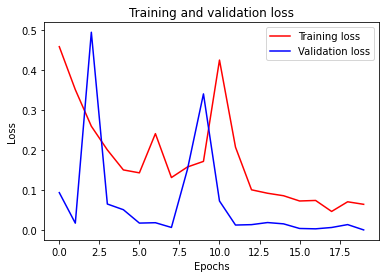

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

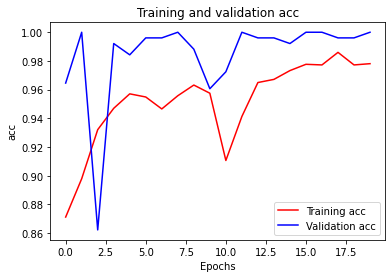

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


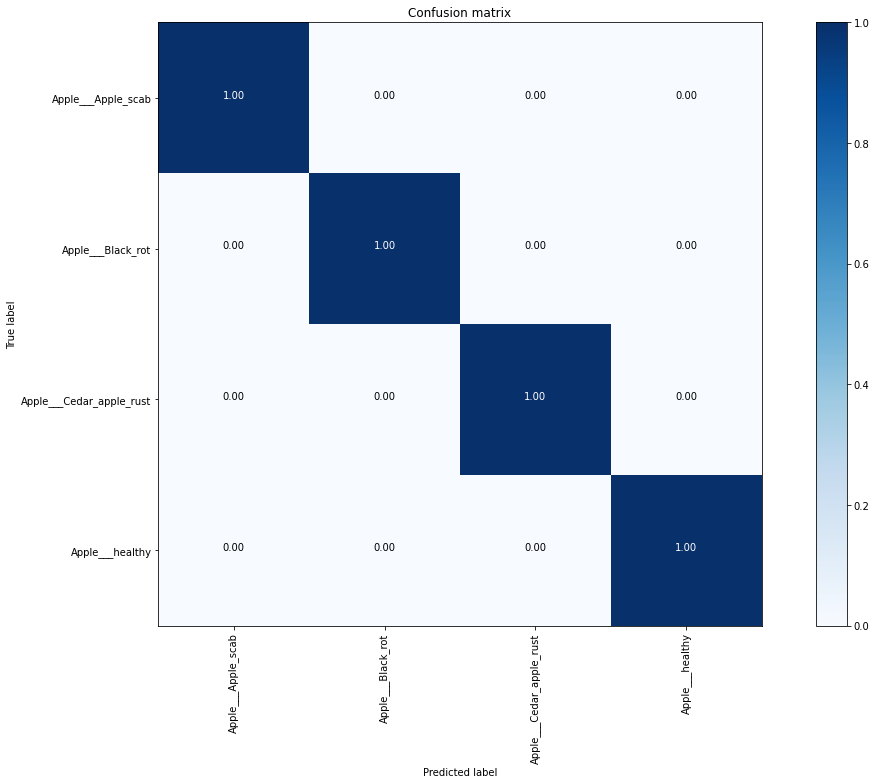

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_resnet, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[50, 50, 22, 132]
4
Accuracy of Apple___Apple_scab	100 %
Accuracy of Apple___Black_rot	100 %
Accuracy of Apple___Cedar_apple_rust	100 %
Accuracy of Apple___healthy	100 %


In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

# Измерим на тестовой выборке знаяя ответы

In [ ]:
test_dataset_metrics = AppleDataset(test_files, mode='val')

# определим загрузщики данных без взвешивания классов для их балансировки простой вариант
# DataLoader достаёт данные из dataset батчами
dataloaders_test = {'val': DataLoader(test_dataset_metrics, batch_size=BATCH_SIZE, shuffle=False)}

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9859
print("Accuracy: {0:.4f}".format(evaluate(model_resnet, dataloaders_test['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9984


Normalized confusion matrix


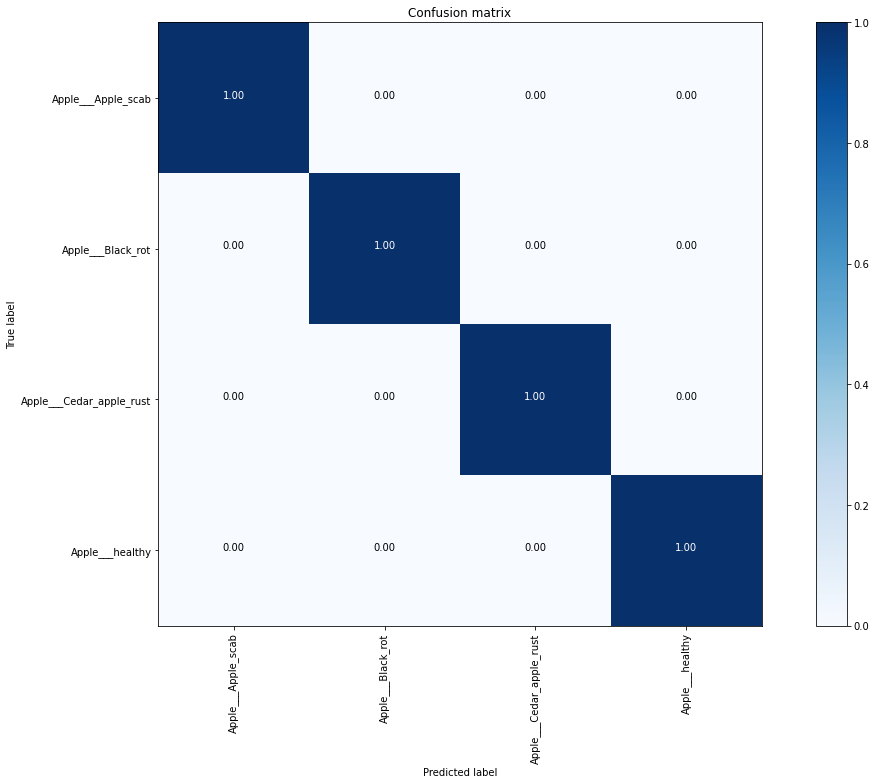

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_resnet, dataloaders_test)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[125, 124, 55, 331]
4
Accuracy of Apple___Apple_scab	100 %
Accuracy of Apple___Black_rot	100 %
Accuracy of Apple___Cedar_apple_rust	100 %
Accuracy of Apple___healthy	99 %


In [ ]:
f1_score(y_test_all, predictions_all, average='macro')

0.9986257692377238

##### Kaggle Submit

In [ ]:
test_dataset = AppleDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(model_resnet, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds}) # Каггле берет только с такими заголовками
my_submit.to_csv(path + '_predict.csv', index=False)

## Сохраним всю модель

In [ ]:
path = '/content/gdrive/MyDrive/AgroCode_pre_snippets/model/ResNet34_DGL_AdamW_aug_oversampling_batchsize_16'
torch.save(model_resnet, path + '_full_model.pth')

# Пример для веба

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import torch
import pickle
import numpy as np
 
from PIL import Image
 
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder

In [ ]:
class DLModelImageClassifier(object):
    """Класс-обертка над моделью нейросети для классифкации картинок"""

    def __init__(self, path_model, path_label_enc):
        # загружаем модель
        # на всякий случай грузим модель для cpu
        self.model = torch.load(path_model, map_location=torch.device('cpu'))
        self.model.eval()

        # загружаем кодировщик названий классов
        with open(path_label_enc, 'rb') as f:
            label_enc = pickle.load(f)
            
        self.label_enc = label_enc

        # определим трансформации картинок для предобработки
        self.our_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Определим устройство, если есть GPU используем его
        # если GPU нет, то CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # перенесем DL-модель на устройство
        self.model.to(self.device)
    
    def transform_image(self, image_path):

        image = Image.open(image_path)

        return self.our_transforms(image).unsqueeze(0)

    def get_prediction(self, image_path):
        # отключаем расчет градиентов, мы только предсказываем
        with torch.no_grad():
            tensor = self.transform_image(image_path=image_path)
            outputs = self.model.forward(tensor.to(self.device))
            _, prediction = torch.max(outputs, 1)
            prediction = prediction.cpu().detach().numpy()

        return self.label_enc.inverse_transform(prediction)[0]

In [ ]:
# путь к сохраненной модели
path_model = '/content/gdrive/MyDrive/AgroCode_pre_snippets/model/ResNet34_DGL_AdamW_aug_oversampling_batchsize_16_full_model.pth'
# путь к сохраненному кодировщику классов
path_label_enc = '/content/gdrive/MyDrive/AgroCode_pre_snippets/model/label_encoder.pkl'

In [ ]:
# создадим экземпляр класса нашнй модели и передадим ей пути к сохраненной нейрости
# и кодировщику классов
web_model = DLModelImageClassifier(path_model, path_label_enc)

In [ ]:
image_path = '/content/gdrive/MyDrive/AgroCode_pre_snippets/pics_example/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'

In [ ]:
# отработал на CPU - сессии Colaba
web_model.device

device(type='cpu')

In [ ]:
%%time
# сделаем предсказание
web_model.get_prediction(image_path)

CPU times: user 206 ms, sys: 17.5 ms, total: 224 ms
Wall time: 1.12 s


'Apple___Apple_scab'

In [ ]:
# отработал на GPU - сессии Colaba
web_model.device

device(type='cuda')

In [ ]:
%%time
# сделаем предсказание
web_model.get_prediction(image_path)

CPU times: user 21 ms, sys: 6.13 ms, total: 27.2 ms
Wall time: 681 ms


'Apple___Apple_scab'